# NuSTAR Solar Pointing Planning

This is an example notebook to help walk through the steps of getting coordinates (RA/Dec and PA angle) for a NuSTAR solar observation using SDO and STEREO projected maps as reference guides.

In [1]:
import map_projection as mp
import datetime
import matplotlib.pyplot as plt
import astropy.units as u
from nustar_pysolar import planning, io

**Issues with nustar_pysolar and conda?** 

Just copy & paste the nustar_pysolar folder in the nust_pysolar folder into your conda environment path then manually install Python's wget via 

```conda install -n environmentName conda-forge::python-wget```

# Observation Day

**Try 5 days from now.** 

Ideally you know the times of the orbits you are planning.

In [2]:
#5 days from now, Orbit 1, middle time of orbit to project to
t_obs_proj = datetime.datetime.now()+datetime.timedelta(days=5)

# define NuSTAR FOV centre in arcsec, [0,0] is sun centre, +West, +North
nustar_center = [500,480] 

# define the NuSTAR field of views you want plotted, 0 is the actual 12x12 arcmin FOV, +/- is in arcseconds
nu_fovs = [-100,0,100]

Define optional inputs...

In [3]:
# NuSTAR FOV anti-clockwise rotation from solar north in degrees (Det0 in top left originally)
nu_SNangle = -30 # default is 0 deg

# define your points of interest x,y locations in arcseconds, plotted as red x
x_poi, y_poi = [450], [600] # default is None

# if you have a PSP footpoint location in arcseconds, plotted as grey square
psp_loc = [-360,-400] # default is None

Now plot...

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

aia20220105_143600_0094.fits:   0%|          | 0.00/4.21M [00:00<?, ?B/s]

Got AIA map.


Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
Got STEREO-A map.
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


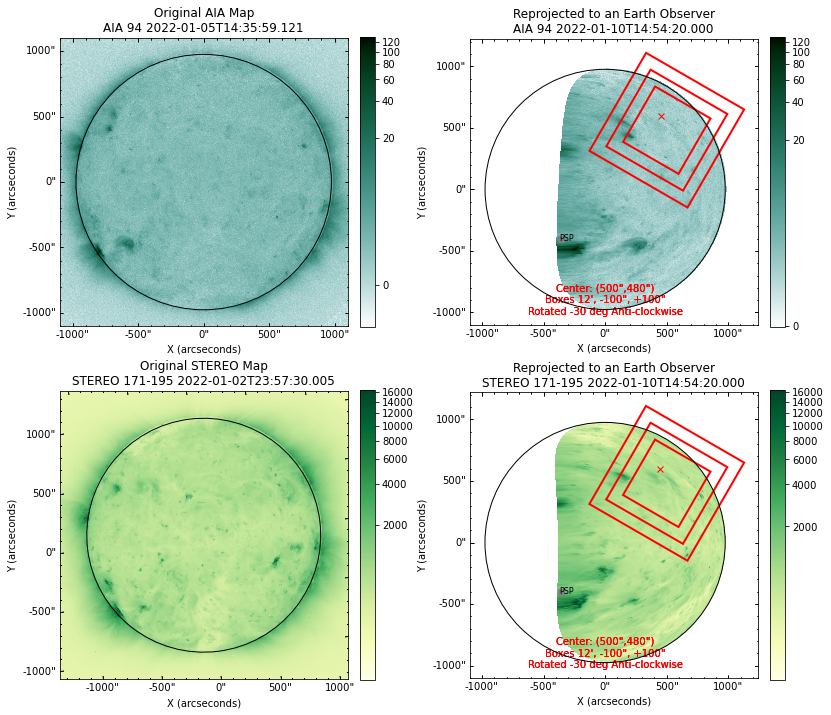

In [4]:
# define the figure
plt.figure(figsize=(13,12))

# create the plots and returns tuple of the 4 axes objects
axes = mp.reprojection(t_obs_proj.strftime("%Y-%m-%dT%H:%M:%S"), *nustar_center, nu_fovs, rotate=nu_SNangle, 
                       markers=[x_poi, y_poi], psp_loc=psp_loc)

# # save out if you like
# plt.savefig('./example_output.jpg', bbox_inches="tight")
plt.show()

***

**Brian Grefenstette's example on NuSTAR solar observation planning is what's needed here (https://github.com/NuSTAR/nustar_pysolar/blob/main/notebooks/Planning_Example.ipynb).**

**I did have to go an manually download the planet ephemeris data file de436.bsp from https://ssd.jpl.nasa.gov/ftp/eph/planets/bsp/ since nustar_pysolar kept timing out with the website. This file is also too large to uplaod to Github.**

You might want to adjust the tstart from above to look over the whole observing period for NuSTAR insterad of just starting at the time the maps are projected onto.

Now we will find the PA angle (in degrees) and the centre of NuSTAR's field of view (in RA/Dec and degrees) for your solar observation planned above from your helioprojective coordinates.

In [5]:
#Define in lists to loop over easily. 

# just need string for when your orbit(s) start
t_obs_starts = [(t_obs_proj-datetime.timedelta(minutes=30)).strftime("%Y-%m-%dT%H:%M:%S")] 

# might want to search over multiple hours if you have multiple orbits
t_obs_durs = [{"hours":2}]

# get end time(s) for seperate runs of orbit(s) 
t_obs_ends = [(datetime.datetime.strptime(t_obs_start, "%Y-%m-%dT%H:%M:%S")+datetime.timedelta(**t_obs_dur)).strftime("%Y-%m-%dT%H:%M:%S") for t_obs_start, t_obs_dur in zip(t_obs_starts, t_obs_durs)]

In [6]:
# Use Brian's planning Notebook: https://github.com/NuSTAR/nustar_pysolar/blob/main/notebooks/Planning_Example.ipynb

for t_obs_start, t_obs_dur, t_obs_end, ang, nustar_centers in zip(t_obs_starts, t_obs_durs, t_obs_ends, [-30,-20], [[[1050, 480], [-700,-100], [-700,-100]], [[-450,-90], [-425,-90], [-400,-90]]]):
    # Get occultation period times
    fname = io.download_occultation_times(outdir='./data/')

    # Define observing window
    orbits = planning.sunlight_periods(fname, tstart=t_obs_start, tend=t_obs_end)

    # Calculate the PA angle
    pa = planning.get_nustar_roll(t_obs_start, ang<<u.deg) # angle is anti-clockwise starting with Det0 in top-left
    print("For a \"square\" field of view, use angle=0 / 90 / 180 / 270 to have DET0 at the NE (top left) / SE / SW / NW\ncorners of a square field of view.")
    print("NuSTAR Roll angle for anti-clockwise rotation of {} deg from SN @ {}: {}\n".format(ang, t_obs_start, pa))

    # Loop over orbits and find pointing in RA/Dec
    print("\nStarting @ ", t_obs_start)
    for ind, orbit in enumerate(orbits):
        offset = nustar_centers[ind]*u.arcsec
        midTime = (0.5*(orbit[1] - orbit[0]) + orbit[0])
        sky_pos = planning.get_skyfield_position(midTime, offset, load_path='./data', parallax_correction=True)
        print("\nOrbit: {}".format(ind))
        print("Orbit start: {} -> Orbit end: {}".format(orbit[0], orbit[1]))
        print('Aim time: {} RA: {}, Dec: {}\n'.format(midTime, sky_pos[0], sky_pos[1]))
    print("\n\n")

For a "square" field of view, use angle=0 / 90 / 180 / 270 to have DET0 at the NE (top left) / SE / SW / NW
corners of a square field of view.
NuSTAR Roll angle for anti-clockwise rotation of -30 deg from SN @ 2022-01-10T14:24:20: 327.4431397171061 deg


Starting @  2022-01-10T14:24:20
100% [........................................................] 360780 / 360780
Orbit: 0
Orbit start: 2022-01-10T14:31:50.000 -> Orbit end: 2022-01-10T15:33:40.000
Aim time: 2022-01-10T15:02:45.000 RA: 291.36567618117544 deg, Dec: -21.8210923791892 deg






***

**Check your orbit times match the time used to project your EUV maps above.**

**Recommended to use 'Aim time' suggested for the orbit as the project time.**

***

***